In [52]:
#####################
# Dependency import #
#####################

import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import json

In [3]:
###################
# Dataset loading #
###################

dt = pd.read_csv('city_temperature.csv')
dt.head(100)

C:\Users\teodo\AppData\Local\Temp\ipykernel_5476\3705457785.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv('city_temperature.csv')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
95,Africa,Algeria,NaN,Algiers,4,6,1995,59.0
96,Africa,Algeria,NaN,Algiers,4,7,1995,54.9
97,Africa,Algeria,NaN,Algiers,4,8,1995,54.2
98,Africa,Algeria,NaN,Algiers,4,9,1995,57.8


In [4]:
#################
# Data cleaning #
#################

dt.drop(columns=["State", "Region"], axis=1, inplace=True)
dt.drop(index=dt.loc[dt["Day"] <= 0].index, inplace=True)
dt.drop(index=dt.loc[dt["AvgTemperature"] <= -20].index, inplace=True)
dt.dropna()

#dt["AvgTemperature"] = dt.apply(lambda row: ((row["AvgTemperature"] - 32 / 1.8) * (5 / 9)), axis=1)

dt

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...
2906322,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,US,San Juan Puerto Rico,7,30,2013,83.8


<Axes: xlabel='Year', ylabel='AvgTemperature'>

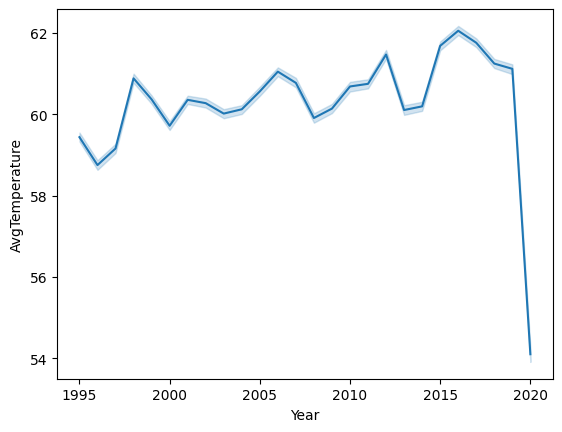

In [5]:
#######################################
# Visualisation of global temperature #
#######################################
sb.lineplot(data=dt, x="Year", y="AvgTemperature")

In [43]:

g_mse_comp = {"Training MSE" : [], "Test MSE": []}
g_mse_comp_indexes = []
g_mse_comp_c_i = 0

g_r2_progression = {"Polynomial degree" : [], "R2": []}
g_mse_progression = {"Polynomial degree" : [], "MSE": []}

tmp = dt.groupby(by=["Day", "Month", "Year"])["AvgTemperature"].mean().reset_index()

mse = None
r2 = None

degree = 1
global_model = None

for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=tmp[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, tmp["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test)
    
    t_predictions = poly_regression.predict(x_train)
    
    t_mse = metrics.mean_squared_error(y_pred=t_predictions, y_true=y_train)
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    print("\n\n")
    print("Training MSE:", t_mse)
    print("MSE:", c_mse)
    print("R2:", c_r2)
    
    
    
    g_mse_comp["Training MSE"].append(t_mse)
    g_mse_comp["Test MSE"].append(c_mse)
    g_mse_comp_indexes.append(g_mse_comp_c_i)
    g_mse_comp_c_i += 1
    
    g_r2_progression["Polynomial degree"].append(i)
    g_r2_progression["R2"].append(c_r2)
    
    g_mse_progression["Polynomial degree"].append(i)
    g_mse_progression["MSE"].append(c_mse)
    
    if mse is None and r2 is None:
        mse = c_mse
        r2 = c_r2 
    else:
        if c_mse < mse:
            global_model = _model
            degree = i
            mse = c_mse
        elif c_r2 > r2:
            global_model = _model
            degree = i
            r2 = c_r2
        else:
            break
        
        
global_temp_model = {"x_intercept": global_model.intercept_, "Beta_Coefficients":  global_model.coef_.tolist(), "polynomial_degree": degree}
model_file = open(file="global_temp_model.json", mode="w")
jf = json.dump(obj=global_temp_model,fp= model_file, indent=4)
model_file.flush()
model_file.close()
del(model_file)


g_comp = pd.DataFrame(data=g_mse_comp, index=g_mse_comp_indexes)
g_r2_prog = pd.DataFrame(data=g_r2_progression, index=g_mse_comp_indexes)
g_mse_prog = pd.DataFrame(data=g_mse_progression, index=g_mse_comp_indexes)

g_comp




Training MSE: 121.38338116006769
MSE: 122.87716864715885
R2: 0.04962565773662364



Training MSE: 16.82819712987915
MSE: 16.845859731847913
R2: 0.8690915900895849



Training MSE: 11.798979680616036
MSE: 11.087923214415676
R2: 0.9135553085756639



Training MSE: 6.025487507151218
MSE: 5.887396655271592
R2: 0.9548742161699604



Training MSE: 5.420251464051602
MSE: 6.247721972180726
R2: 0.9518610686758692



Training MSE: 5.61827606058547
MSE: 6.3327518663323294
R2: 0.9519510354715873



Training MSE: 6.509643715488773
MSE: 6.5299330915881475
R2: 0.9498855132366193


,Training MSE,Test MSE
0,121.383381,122.877169
1,16.828197,16.845860
2,11.798980,11.087923
3,6.025488,5.887397
4,5.420251,6.247722
5,5.618276,6.332752
6,6.509644,6.529933


Text(0.5, 0, 'Iteration')

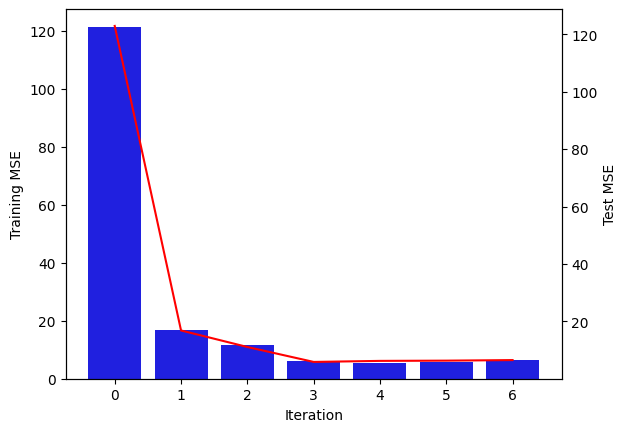

In [68]:
##########################################################################################
# Comparison of the MSE in predicting training data VS testing data for the Global model #
##########################################################################################
p1 = sb.barplot(data=g_comp, x=g_comp.index, y="Training MSE", color="b")
p1.set_xlabel("Iteration")
plt.twinx()
p2 = sb.lineplot(data=g_comp, x=g_comp.index, y="Test MSE",color="r")
p2.set_xlabel("Iteration")

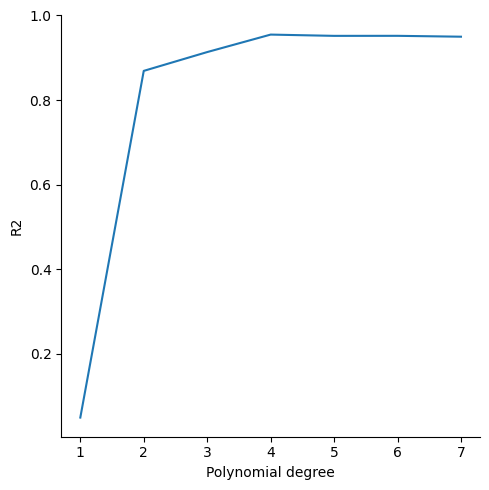

In [72]:
#########################################################################################################
# Visualisation of the R2 score progression in relation with the polynomial degree for the Global model #
#########################################################################################################

sb.relplot(data= g_r2_prog, x="Polynomial degree", y="R2", kind="line")

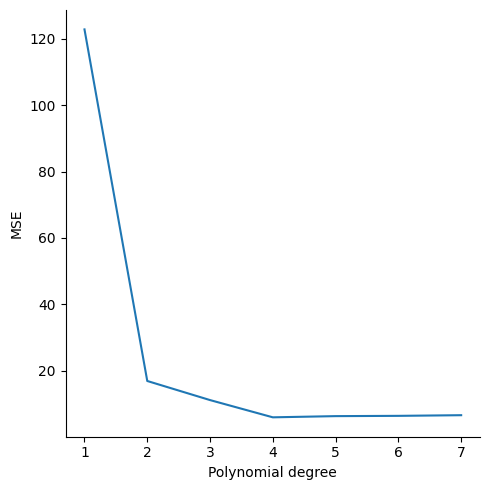

In [73]:
##########################################################################################################
# Visualisation of the MSE score progression in relation with the polynomial degree for the Global model #
##########################################################################################################

sb.relplot(data= g_mse_prog, x="Polynomial degree", y="MSE", kind="line")

<Axes: xlabel='Year', ylabel='AvgTemperature'>

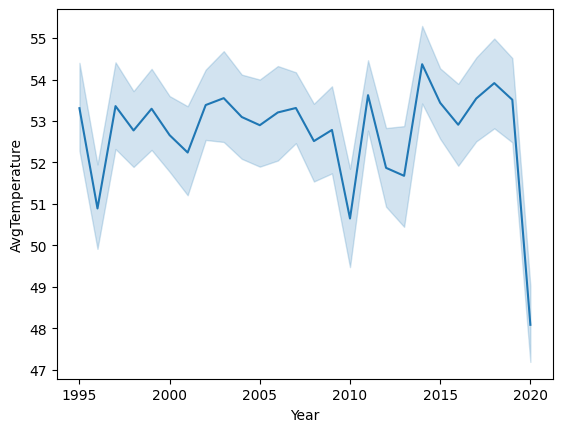

In [7]:
#########################################
# Visualisation of London's temperature #
#########################################

dtl =  dt[(dt['Country'] == 'United Kingdom') & (dt['City'] == 'London')]
sb.lineplot(data=dtl, x="Year", y="AvgTemperature")

In [34]:
l_mse_comp = {"Training MSE" : [], "Test MSE": []}
l_mse_comp_indexes = []
l_mse_comp_c_i = 0

l_r2_progression = {"Polynomial degree" : [], "R2": []}
l_mse_progression = {"Polynomial degree" : [], "MSE": []}

mse = None
r2 = None

mse = None
r2 = None

l_degree = 1
l_model = None

for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=dtl[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, dtl["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test)
    
    t_predictions = poly_regression.predict(x_train)
    
    t_mse = metrics.mean_squared_error(y_pred=t_predictions, y_true=y_train)
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    print("\n\n")
    print("Training MSE:", t_mse)
    print("MSE:", mse)
    print("R2:", r2)
    
    
    l_mse_comp["Training MSE"].append(t_mse)
    l_mse_comp["Test MSE"].append(c_mse)
    l_mse_comp_indexes.append(g_mse_comp_c_i)
    l_mse_comp_c_i += 1
    
    l_r2_progression["Polynomial degree"].append(i)
    l_r2_progression["R2"].append(c_r2)
    
    l_mse_progression["Polynomial degree"].append(i)
    l_mse_progression["MSE"].append(c_mse)
    
    if mse is None and r2 is None:
        mse = c_mse
        r2 = c_r2 
    else:
        if c_mse < mse:
            l_model = _model
            l_degree = i
            mse = c_mse
        elif c_r2 > r2:
            l_model = _model
            l_degree = i
            r2 = c_r2
        else:
            break

london_temp_model = {"x_intercept": l_model.intercept_, "Beta_Coefficients":  l_model.coef_.tolist(), "polynomial_degree": l_degree}
model_file = open(file="london_temp_model.json", mode="w")
jf = json.dump(obj=london_temp_model,fp= model_file, indent=4)
model_file.flush()
model_file.close()
del(model_file)

l_comp = pd.DataFrame(data=l_mse_comp, index=l_mse_comp_indexes)
l_r2_prog = pd.DataFrame(data=l_r2_progression, index=l_mse_comp_indexes)
l_mse_prog = pd.DataFrame(data=l_mse_progression, index=l_mse_comp_indexes)




Training MSE: 93.8876541159724
MSE: None
R2: None



Training MSE: 38.77246242019254
MSE: 96.08313491560794
R2: 0.05792842785486019



Training MSE: 31.86484706144918
MSE: 38.421935187779326
R2: 0.05792842785486019



Training MSE: 26.65642058777809
MSE: 33.09222323786675
R2: 0.05792842785486019



Training MSE: 25.710837623133536
MSE: 27.445523347651783
R2: 0.05792842785486019



Training MSE: 25.851780328234383
MSE: 26.841032386122198
R2: 0.05792842785486019



Training MSE: 26.107815588289768
MSE: 26.299338461860803
R2: 0.05792842785486019



Training MSE: 27.999939182921384
MSE: 25.498190599527952
R2: 0.05792842785486019



Training MSE: 26.21725061211499
MSE: 25.498190599527952
R2: 0.7143724010350323



Training MSE: 25.55250500774823
MSE: 25.479732827915505
R2: 0.7143724010350323



Training MSE: 25.688382838364372
MSE: 25.479732827915505
R2: 0.7276432418938417



Training MSE: 25.569637140852144
MSE: 25.479732827915505
R2: 0.7411267006537392


,Country,City,Month,Day,Year,AvgTemperature
986835,United Kingdom,London,1,1,1995,34.2
986836,United Kingdom,London,1,2,1995,32.6
986837,United Kingdom,London,1,3,1995,30.9
986838,United Kingdom,London,1,4,1995,37.7
986839,United Kingdom,London,1,5,1995,39.5
...,...,...,...,...,...,...
996096,United Kingdom,London,5,9,2020,64.1
996097,United Kingdom,London,5,10,2020,54.1
996098,United Kingdom,London,5,11,2020,47.0
996099,United Kingdom,London,5,12,2020,48.9


Text(0.5, 0, 'Iteration')

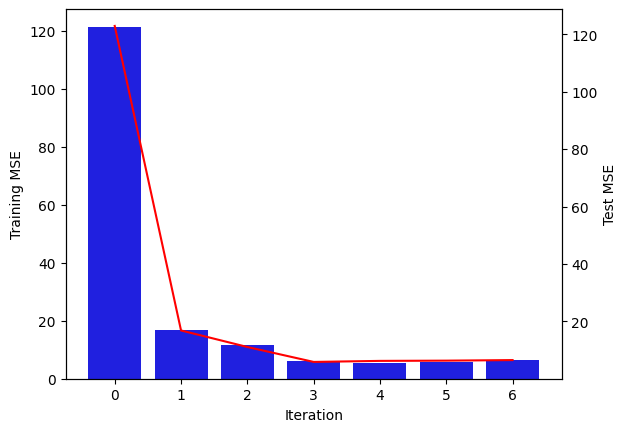

In [74]:
##########################################################################################
# Comparison of the MSE in predicting training data VS testing data for the Global model #
##########################################################################################
p1 = sb.barplot(data=g_comp, x=g_comp.index, y="Training MSE", color="b")
p1.set_xlabel("Iteration")
plt.twinx()
p2 = sb.lineplot(data=g_comp, x=g_comp.index, y="Test MSE",color="r")
p2.set_xlabel("Iteration")

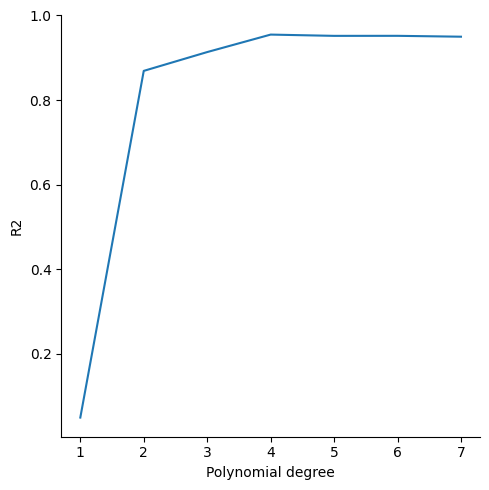

In [75]:
#########################################################################################################
# Visualisation of the R2 score progression in relation with the polynomial degree for the Global model #
#########################################################################################################

sb.relplot(data= g_r2_prog, x="Polynomial degree", y="R2", kind="line")

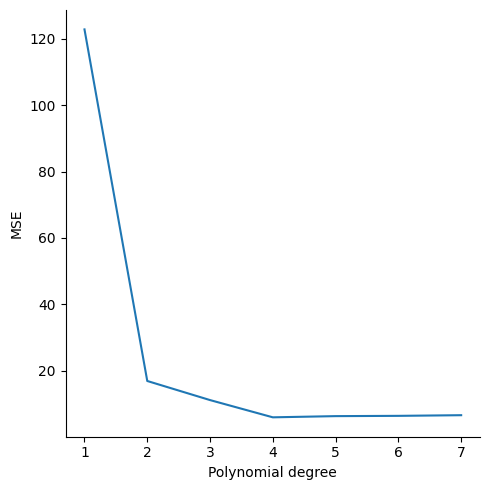

In [76]:
##########################################################################################################
# Visualisation of the MSE score progression in relation with the polynomial degree for the Global model #
##########################################################################################################

sb.relplot(data= g_mse_prog, x="Polynomial degree", y="MSE", kind="line")